# Pre_Processing & Feature engineering

# Bloc 1 : Imports et initialisation des chemins

In [ ]:
import os
import shutil
import random
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm  
from PIL import Image, ImageEnhance

In [ ]:

# Définition des chemins
original_dataset_path = r"C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_bis"  # Dossier original contenant train, test, val
new_dataset_path = "C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_t/"  # Nouveau dossier pour stocker les images échantillonnées
subfolders = ["train", "test", "val"]

# Création des dossiers de destination
for subfolder in subfolders:
    os.makedirs(os.path.join(new_dataset_path, subfolder), exist_ok=True)

# ---- 1. Charger un modèle pré-entraîné pour extraire des features ----
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Mise à jour de la syntaxe
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Supprimer la dernière couche de classification
model.eval()

# Transformation pour adapter les images au modèle
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---- 2. Extraction des features ----
def extract_features(image_path):
    """Charge une image, la transforme et extrait ses features avec ResNet18"""
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Ajouter une dimension batch
    with torch.no_grad():
        feature = model(image).squeeze().numpy()  # Extraire les features
    return feature.flatten()  # Aplatir en 1D

# Dictionnaire pour stocker les features et les chemins des images
features_dict = {subfolder: [] for subfolder in subfolders}
image_paths_dict = {subfolder: [] for subfolder in subfolders}

# Bloc 2 : Échantillonnage d’images

In [1]:
# Limites du nombre d'images à extraire par dossier
limits = {"train": 30000, "test": 3000, "val": 3000}

# Extraction des features pour chaque sous-dossier (train, test, val)
for subfolder in subfolders:
    folder_path = os.path.join(original_dataset_path, subfolder)
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))]
    
    # Appliquer la limite spécifique à chaque dossier
    image_files = image_files[:limits[subfolder]]

    for img_path in tqdm(image_files, desc=f"Extraction {subfolder}"):
        features_dict[subfolder].append(extract_features(img_path))
        image_paths_dict[subfolder].append(img_path)

# ---- 3. Réduction de dimension avec PCA ----
for subfolder in subfolders:
    if len(features_dict[subfolder]) > 0:  # Vérifier qu'il y a des images avant PCA
        n_components = min(50, len(features_dict[subfolder]))  # Ajuster n_components pour éviter l'erreur
        pca = PCA(n_components=n_components)
        features_dict[subfolder] = pca.fit_transform(features_dict[subfolder])

# ---- 4. Clustering & Échantillonnage ----
n_clusters = 54  # Nombre de clusters

def stratified_sampling(features, image_paths):
    """Regroupe les images par clusters et sélectionne un sous-ensemble équilibré"""
    if len(features) == 0:
        return []
    
    kmeans = KMeans(n_clusters=min(n_clusters, len(features)), random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)

    clusters = {i: [] for i in range(n_clusters)}
    for img_path, label in zip(image_paths, labels):
        clusters[label].append(img_path)

    sampled_images = []
    for cluster_id, images in clusters.items():
        sampled_images.extend(images)
    
    return sampled_images

# Dictionnaire contenant les images sélectionnées par sous-dossier
sampled_images_dict = {subfolder: stratified_sampling(features_dict[subfolder], image_paths_dict[subfolder]) for subfolder in subfolders}

# ---- 5. Sauvegarde des images sélectionnées dans images_bis/ ----
for subfolder in subfolders:
    new_subfolder_path = os.path.join(new_dataset_path, subfolder)

    for img_path in tqdm(sampled_images_dict[subfolder], desc=f"Copie {subfolder}"):
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(new_subfolder_path, filename))

print("✅ Échantillonnage terminé et images copiées dans 'images_bis/' avec la même organisation.")



Copie val: 100%|██████████| 3000/3000 [00:43<00:00, 68.87it/s] 

✅ Échantillonnage terminé et images copiées dans 'images_bis/' avec la même organisation.


# Bloc 3 : Réduction de la dominance du rouge et amélioration de la netteté 

In [10]:
import os
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm

#Définition des chemins
dataset_path = r"C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_bis"
subfolders = {"train_bis": 500, "test_bis": 50, "val_bis": 50}  # Nombre d'images à sélectionner


# Création des dossiers de sortie pour les images améliorées
for subfolder in subfolders:
    output_folder = os.path.join(dataset_path, f"{subfolder}_bis")
    os.makedirs(output_folder, exist_ok=True)

# Fonction pour améliorer la netteté
def enhance_sharpness(image_path, factor=2.5):
    """Améliore la netteté d'une image avec un facteur donné."""
    image = Image.open(image_path).convert("RGB")
    enhancer = ImageEnhance.Sharpness(image)
    return enhancer.enhance(factor)

# Sélection et amélioration des images
for subfolder, num_images in subfolders.items():
    folder_path = os.path.join(dataset_path, subfolder)
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))]
    
    # Sélectionner un sous-échantillon
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    
    output_folder = os.path.join(dataset_path, f"{subfolder}_bis")
    
    for img_path in tqdm(selected_images, desc=f"Amélioration des images {subfolder}"):
        sharpened_image = enhance_sharpness(img_path)
        
        # Sauvegarde de l'image améliorée
        output_file = os.path.join(output_folder, os.path.basename(img_path))
        sharpened_image.save(output_file)

print("✅ Amélioration de netteté terminée. Images enregistrées dans les dossiers 'train_bis', 'test_bis' et 'val_bis'.")


Amélioration des images train_bis: 0it [00:00, ?it/s]
Amélioration des images test_bis: 0it [00:00, ?it/s]
Amélioration des images val_bis: 0it [00:00, ?it/s]

✅ Amélioration de netteté terminée. Images enregistrées dans les dossiers 'train_bis', 'test_bis' et 'val_bis'.


In [1]:


# Définition des chemins
dataset_path = "C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_bis/"
subfolders = {"train_bis": 5000, "test_bis": 500, "val_bis": 500}  # Nombre d'images à sélectionner

# Liste pour stocker les noms des images corrigées
corrected_images_list = []

# Fonction pour réduire la dominance du rouge
def reduce_red(image_path, reduction_factor=0.9):
    """Réduit l'intensité du rouge dans une image en ajustant la composante R."""
    image = Image.open(image_path).convert("RGB")
    img_array = np.array(image, dtype=np.float32)
    img_array[..., 0] *= reduction_factor  # Réduction du canal rouge (R)
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    return Image.fromarray(img_array)

# Sélection et correction des images
for subfolder, num_images in subfolders.items():
    folder_path = os.path.join(dataset_path, subfolder)
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))]
    
    # Sélectionner un sous-échantillon
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    
    for img_path in tqdm(selected_images, desc=f"Correction des images {subfolder}"):
        corrected_image = reduce_red(img_path)
        
        # Sauvegarde en remplaçant l'image originale
        corrected_image.save(img_path)
        
        # Ajouter l'image corrigée à la liste
        corrected_images_list.append(os.path.basename(img_path))

# Affichage des 5 premières images corrigées
print("✅ Correction du rouge terminée. Les images existantes ont été remplacées.")
print("✅ 5 images corrigées :", corrected_images_list[:5])



Correction des images val_bis: 100%|██████████| 500/500 [00:12<00:00, 40.56it/s]


✅ Correction du rouge terminée. Les images existantes ont été remplacées.
✅ 5 images corrigées : ['image_971045975_product_261224106.jpg', 'image_963906571_product_245155230.jpg', 'image_971203657_product_260978007.jpg', 'image_985245839_product_289431804.jpg', 'image_970911889_product_260458769.jpg']


# Bloc 4 : Augmentation de la saturation

In [3]:

# Définition des chemins
dataset_path = "C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_bis/"
subfolders = ["train_bis", "test_bis", "val_bis"]

# Facteur d'augmentation de la saturation
saturation_factor = 1.2  # Augmenter de 20%

# Appliquer la correction sur tout le dataset
for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))]
    
    for img_path in tqdm(image_files, desc=f"Augmentation de la saturation ({subfolder})"):
        image = Image.open(img_path).convert("RGB")
        enhancer = ImageEnhance.Color(image)
        enhanced_image = enhancer.enhance(saturation_factor)  # Augmenter la saturation
        
        # Remplacer l'image originale
        enhanced_image.save(img_path)

print("✅ Augmentation de saturation terminée. Toutes les images ont été mises à jour.")

Augmentation de la saturation (val_bis): 100%|██████████| 500/500 [00:16<00:00, 31.12it/s]

✅ Augmentation de saturation terminée. Toutes les images ont été mises à jour.


#  Bloc 5 : Ajustement de la luminosité sur une partie des images

In [5]:

# Définition des chemins
dataset_path = "C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_bis/"
subfolders = ["train_bis", "test_bis", "val_bis"]

# Proportion des images à ajuster
adjustment_ratio = 0.3  # 30% des images
brightness_factor_range = (0.85, 1.15)  # Ajustement entre -15% et +15%

# Appliquer la correction sur une partie du dataset
for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))]
    
    # Sélectionner aléatoirement 30% des images
    selected_images = random.sample(image_files, int(len(image_files) * adjustment_ratio))
    
    for img_path in tqdm(selected_images, desc=f"Ajustement léger de la luminosité ({subfolder})"):
        image = Image.open(img_path).convert("RGB")
        enhancer = ImageEnhance.Brightness(image)
        brightness_factor = random.uniform(*brightness_factor_range)  # Facteur aléatoire entre 0.85 et 1.15
        adjusted_image = enhancer.enhance(brightness_factor)  # Ajuster la luminosité
        
        # Remplacer l'image originale
        adjusted_image.save(img_path)

print("✅ Ajustement de la luminosité terminé. 30% des images ont été légèrement modifiées.")


Ajustement léger de la luminosité (val_bis): 100%|██████████| 150/150 [00:04<00:00, 35.49it/s]

✅ Ajustement de la luminosité terminé. 30% des images ont été légèrement modifiées.


# Vérification des modifications effectuées:

Vérification des transformations (val_bis): 100%|██████████| 500/500 [00:26<00:00, 18.55it/s]


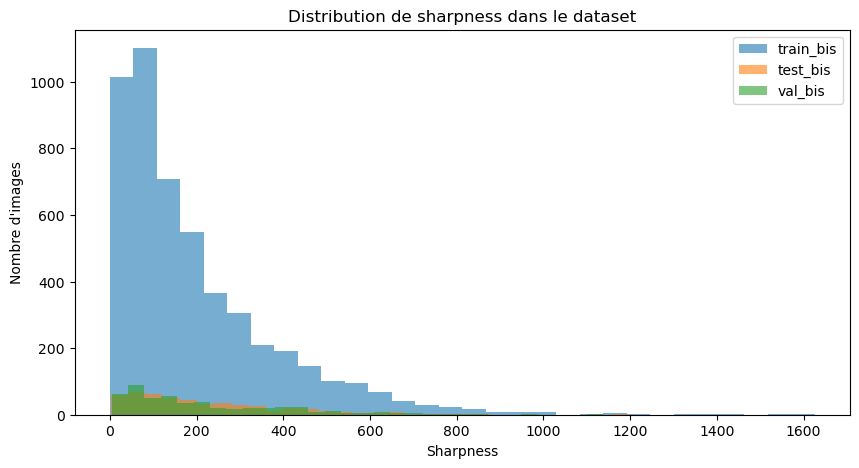

train_bis - Sharpness moyenne: 197.288
test_bis - Sharpness moyenne: 219.010
val_bis - Sharpness moyenne: 213.634


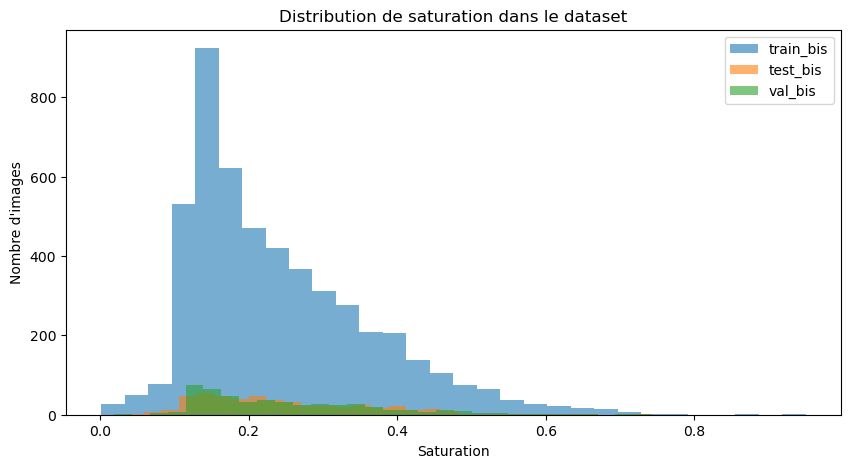

train_bis - Saturation moyenne: 0.242
test_bis - Saturation moyenne: 0.249
val_bis - Saturation moyenne: 0.251


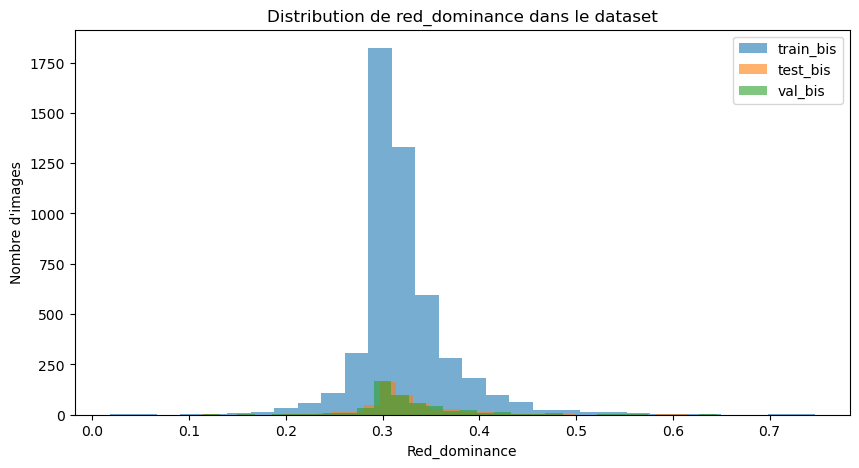

train_bis - Red_dominance moyenne: 0.321
test_bis - Red_dominance moyenne: 0.324
val_bis - Red_dominance moyenne: 0.325


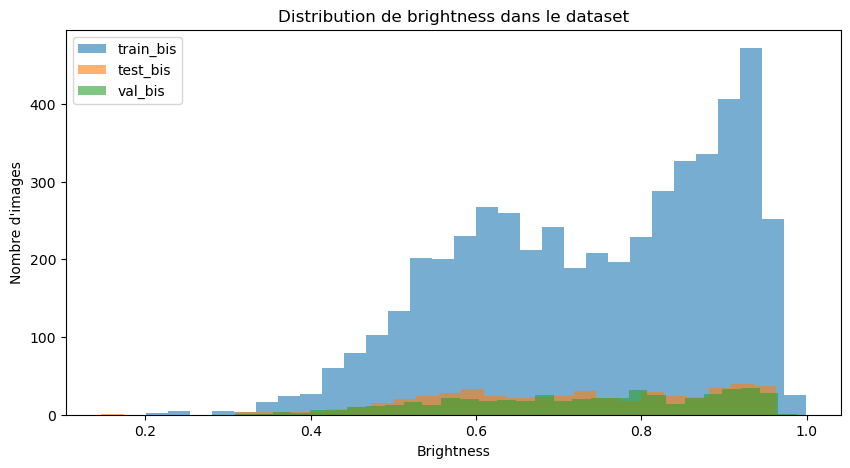

train_bis - Brightness moyenne: 0.743
test_bis - Brightness moyenne: 0.717
val_bis - Brightness moyenne: 0.731


In [7]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Définition des chemins
dataset_path = "C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_bis/"
subfolders = ["train_bis", "test_bis", "val_bis"]

# Fonction pour calculer la netteté moyenne
def calculate_sharpness(image_path):
    image = Image.open(image_path).convert("L")
    img_array = np.array(image, dtype=np.float32)
    laplacian = np.var(np.gradient(img_array))  # Variation des gradients
    return laplacian

# Fonction pour calculer la saturation moyenne
def calculate_saturation(image_path):
    image = Image.open(image_path).convert("RGB").convert("HSV")
    img_array = np.array(image, dtype=np.float32)
    S = img_array[..., 1]
    return np.mean(S) / 255.0

# Fonction pour calculer la dominance du rouge
def calculate_red_dominance(image_path):
    image = Image.open(image_path).convert("RGB")
    img_array = np.array(image, dtype=np.float32)
    R, G, B = img_array[..., 0], img_array[..., 1], img_array[..., 2]
    return np.mean(R / (R + G + B + 1e-5))  # Éviter la division par zéro

# Fonction pour calculer la luminosité moyenne
def calculate_brightness(image_path):
    image = Image.open(image_path).convert("YCbCr")
    img_array = np.array(image, dtype=np.float32)
    Y_channel = img_array[..., 0]
    return np.mean(Y_channel) / 255.0

# Collecte des métriques
dataset_metrics = {"sharpness": {}, "saturation": {}, "red_dominance": {}, "brightness": {}}

for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))]
    
    sharpness_values, saturation_values, red_values, brightness_values = [], [], [], []
    
    for img_path in tqdm(image_files, desc=f"Vérification des transformations ({subfolder})"):
        sharpness_values.append(calculate_sharpness(img_path))
        saturation_values.append(calculate_saturation(img_path))
        red_values.append(calculate_red_dominance(img_path))
        brightness_values.append(calculate_brightness(img_path))
    
    dataset_metrics["sharpness"][subfolder] = sharpness_values
    dataset_metrics["saturation"][subfolder] = saturation_values
    dataset_metrics["red_dominance"][subfolder] = red_values
    dataset_metrics["brightness"][subfolder] = brightness_values

# Affichage des métriques
for metric, values in dataset_metrics.items():
    plt.figure(figsize=(10, 5))
    for subfolder, data in values.items():
        plt.hist(data, bins=30, alpha=0.6, label=subfolder)
    plt.xlabel(metric.capitalize())
    plt.ylabel("Nombre d'images")
    plt.title(f"Distribution de {metric} dans le dataset")
    plt.legend()
    plt.show()
    
    for subfolder, data in values.items():
        print(f"{subfolder} - {metric.capitalize()} moyenne: {np.mean(data):.3f}")


# Gestion des Doublons :


In [22]:
import hashlib

# Définition du chemin des images à analyser
image_dataset_path = "C:\\Users\\sofia\\Rakuten\\Nettoyage\\images_bis/"
subfolders = ["train", "test", "val"]

# Fonction pour calculer le hash d'une image
def get_image_hash(image_path):
    """Calcule le hash d'une image pour détecter les doublons."""
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Dictionnaires pour stocker les doublons
duplicate_same_name = []  # Doublons avec le même nom de fichier
duplicate_diff_name = []  # Doublons avec des noms différents

# Stocker les hashes et noms de fichiers
hash_dict = {}

# Analyse des images pour détecter les doublons
for subfolder in subfolders:
    folder_path = os.path.join(image_dataset_path, subfolder)
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))]
    
    # Limiter l'échantillon à 100 images pour le test
    image_files = image_files[:100]
    
    for img_path in tqdm(image_files, desc=f"Vérification des doublons {subfolder}"):
        img_hash = get_image_hash(img_path)
        filename = os.path.basename(img_path)
        
        if img_hash in hash_dict:
            if filename in hash_dict[img_hash]:
                duplicate_same_name.append(img_path)
            else:
                duplicate_diff_name.append(img_path)
        else:
            hash_dict[img_hash] = []
        
        hash_dict[img_hash].append(filename)

print("✅ Détection des doublons terminée.")
print(f"Doublons (même nom) trouvés : {len(duplicate_same_name)}")
print(f"Doublons (noms différents) trouvés : {len(duplicate_diff_name)}")

Vérification des doublons val: 100%|██████████| 30/30 [00:00<00:00, 94.82it/s] 

✅ Détection des doublons terminée.
Doublons (même nom) trouvés : 0
Doublons (noms différents) trouvés : 7
